In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import cantera as ct

In [2]:
# global variables
lambda_s = 13.8 # J/s/m/K
Uw = 500 # J/s/m2/K
reactor_length = 5 # m   
bed_diameter = 9.2e-03 # m
epsilon = 0.5
d_cat = 2500 # kg/m3
d_bulk = (1-epsilon)*d_cat # kg/m3
reactor_area = (3.14*bed_diameter**2)/4 # m2
d_particle = 0.425e-03 # m
psi = 1
ssa = 12.408e03 # m2/kg
av = 4/bed_diameter # m2/m3
tau = 1/epsilon # tortuosity factor
q_mL = 100 # mL/min 
q_m3 = q_mL/1e06/60 # m3/s
velo = q_m3/reactor_area # m/s
Tw = 740 # wall temperature
pressure = 1 # bar

print('solid thermal conductivity:', lambda_s, 'J/s/m/K')
print('overall heat transfer coefficient:', Uw, 'J/s/m2/K')
print('reactor length:', reactor_length, 'm')
print('bed diameter:', bed_diameter, 'm')
print('catalyst density:', d_cat, 'kg/m3')
print('bulk density:', d_bulk, 'kg/m3')
print('PFR reactor area: {:.2e}'.format(reactor_area), 'm2')
print('particle diameter: {:.2e}'.format(d_particle), 'm')
print('shape factor:', psi, 'dimensionless')
print('specific surface area of catalyst:', ssa, 'm2/kg')
print('external catalyst surface area: {:.2e}'.format(av), 'm2/m3')
print('tortuosity factor:', tau, 'dimensionless')
print('volumetric flow rate:', q_mL, 'mL/min')
print('volumetric flow rate: {:.2e}'.format(q_m3), 'm3/s')
print('superficial velocity: {:.2f}'.format(velo), 'm/s')

solid thermal conductivity: 13.8 J/s/m/K
overall heat transfer coefficient: 500 J/s/m2/K
reactor length: 5 m
bed diameter: 0.0092 m
catalyst density: 2500 kg/m3
bulk density: 1250.0 kg/m3
PFR reactor area: 6.64e-05 m2
particle diameter: 4.25e-04 m
shape factor: 1 dimensionless
specific surface area of catalyst: 12408.0 m2/kg
external catalyst surface area: 4.35e+02 m2/m3
tortuosity factor: 2.0 dimensionless
volumetric flow rate: 100 mL/min
volumetric flow rate: 1.67e-06 m3/s
superficial velocity: 0.03 m/s


In [3]:
# set 100 points from 500-800 celcius
T = np.linspace(873, 1123, 100)

# set points for pressure and molar ratios
P = np.linspace(101325,  101325, len(T))
ych4 = np.linspace(0.3, 0.3, len(T))
yco2 = np.linspace(0.2, 0.2, len(T))
yh2o = np.linspace(0.0, 0.0, len(T))
yh2 = np.linspace(0.0, 0.0, len(T))
yco = np.linspace(0.0, 0.0, len(T))
yar = np.linspace(0.5, 0.5, len(T))

In [4]:
# literature information contained in the NIST SOURCE Data Archive - https://webbook.nist.gov/
# CH4 + H2O ⇌ CO + 3H2 - SRM1 reaction

def thermSRM1(T): 
    
    t = T/1000            
    WBi = np.array([
          [25.56759,  6.096130,     4.054656,  -2.671301,  0.131021, -118.0089, 227.3665,   -110.5271],  #CO
          [-0.703029, 108.4773,    -42.52157,   5.862788,  0.678565, -76.84376, 158.7163,   -74.87310],  #CH4
          [30.09200,  6.832514,     6.793435,  -2.534480,  0.082139, -250.8810, 223.3967,   -241.8264],  #H2O
          [33.066178, -11.363417,  11.432816,  -2.772874, -0.158558, -9.980797, 172.707974,    0.0]      #H2
          ])
    
    
    # heats of formation at 298.15 K for 'CO', 'CH4', 'H2O', 'H2'
    Hfi_298 = np.array([-110.53, -74.85, -241.826, 0.0]) # kJ/mol
     
    Sfi_298 = np.array([197.66, 186.25, 188.84, 130.68]) # J/mol*K
    
    Stoichiometry = np.array([ 1,    # 'CO'
                              -1,    # 'CH4'
                              -1,    # 'H2O'
                               3])   # 'H2'
    
    Hrxn298 = np.dot(Hfi_298, Stoichiometry)
    Srxn298 = np.dot(Sfi_298, Stoichiometry)
    Grxn298 = Hrxn298 - 298.15*(Srxn298)/1000
    
    T_Hi = np.array([t,  t**2 / 2.0, t**3 / 3.0, t**4 / 4.0, -1.0 / t, 1.0, 0.0, -1.0], dtype="object")
    T_Si = np.array([np.log(t), t,  t**2 / 2.0,  t**3 / 3.0, -1.0 / (2.0 * t**2), 0.0, 1.0, 0.0], dtype="object")
    
    Hi = np.dot(WBi, T_Hi)        # (H - H_298.15) kJ/mol
    Si = np.dot(WBi, T_Si/1000.0) # absolute entropy kJ/mol/K
    
    Hi_stoichiometry = Hi*Stoichiometry
    Si_stoichiometry = Si*Stoichiometry
    
    sum_Hi = sum(Hi_stoichiometry)
    sum_Si = sum(Si_stoichiometry)
    
    Hrxn = Hrxn298 + sum_Hi
    Grxn = Hrxn - T*sum_Si

    R = 8.314e-3 # kJ/mol/K
    
    Keq = np.exp(-Grxn/R/T)
    
    return np.array([Keq, Hrxn])

Hrxn_SRM1 = 1000*thermSRM1(T)[1] # J/mol

In [5]:
# literature information contained in the NIST SOURCE Data Archive - https://webbook.nist.gov/
# CH4 + 2H2O ⇌ CO2 + 4H2 - SRM2 reaction

def thermSRM2(T):

    t = T/1000                  
    WBi = np.array([
          [24.99735,  55.18696,   -33.69137,    7.948387, -0.136638, -403.6075, 228.2431,   -393.5224],  #CO2
          [-0.703029, 108.4773,    -42.52157,   5.862788,  0.678565, -76.84376, 158.7163,   -74.87310],  #CH4
          [30.09200,  6.832514,     6.793435,  -2.534480,  0.082139, -250.8810, 223.3967,   -241.8264],  #H2O
          [33.066178, -11.363417,  11.432816,  -2.772874, -0.158558, -9.980797, 172.707974,    0.0]      #H2
          ])
    

    # heats of formation at 298.15 K for 'CO2', 'CH4', 'H2O', 'H2'
    Hfi_298 = np.array([-393.51, -74.85, -241.826, 0.0]) # kJ/mol
     
    Sfi_298 = np.array([213.79, 186.25, 188.84, 130.68]) # J/mol*K
    
    Stoichiometry = np.array([ 1,    # 'CO2'
                              -1,    # 'CH4'
                              -2,    # 'H2O'
                               4])   # 'H2'
    
    Hrxn298 = np.dot(Hfi_298, Stoichiometry)
    Srxn298 = np.dot(Sfi_298, Stoichiometry)
    Grxn298 = Hrxn298 - 298.15*(Srxn298)/1000
    
    T_Hi = np.array([t,  t**2 / 2.0, t**3 / 3.0, t**4 / 4.0, -1.0 / t, 1.0, 0.0, -1.0], dtype="object")
    T_Si = np.array([np.log(t), t,  t**2 / 2.0,  t**3 / 3.0, -1.0 / (2.0 * t**2), 0.0, 1.0, 0.0], dtype="object")
    
    Hi = np.dot(WBi, T_Hi)        # (H - H_298.15) kJ/mol
    Si = np.dot(WBi, T_Si/1000.0) # absolute entropy kJ/mol/K
    
    Hi_stoichiometry = Hi*Stoichiometry
    Si_stoichiometry = Si*Stoichiometry
    
    sum_Hi = sum(Hi_stoichiometry)
    sum_Si = sum(Si_stoichiometry)
    
    Hrxn = Hrxn298 + sum_Hi
    Grxn = Hrxn - T*sum_Si
    
    R = 8.314e-3 # kJ/mol/K
    
    Keq = np.exp(-Grxn/R/T)
    
    return np.array([Keq, Hrxn])

Hrxn_SRM2 = 1000*thermSRM2(T)[1] # J/mol

In [6]:
# literature information contained in the NIST SOURCE Data Archive - https://webbook.nist.gov/
# CO + H2O ⇌ CO2 + H2 - WGS reaction

def thermWGS(T):   

    t = T/1000                 
    WBi = np.array([
          [25.56759,  6.096130,     4.054656,  -2.671301,  0.131021, -118.0089, 227.3665,   -110.5271],  #CO
          [30.09200,  6.832514,     6.793435,  -2.534480,  0.082139, -250.8810, 223.3967,   -241.8264],  #H2O
          [24.99735,  55.18696,   -33.69137,    7.948387, -0.136638, -403.6075, 228.2431,   -393.5224],  #CO2
          [33.066178, -11.363417,  11.432816,  -2.772874, -0.158558, -9.980797, 172.707974,    0.0]      #H2
          ])
    
    
    # heats of formation at 298.15 K for 'CO', 'H2O', 'CO2', 'H2'
    Hfi_298 = np.array([-110.53, -241.826, -393.51, 0.0]) # kJ/mol
     
    Sfi_298 = np.array([197.66, 188.84, 213.79, 130.68]) # J/mol*K
    
    Stoichiometry = np.array([-1,    # 'CO'
                              -1,    # 'H2O'
                               1,    # 'CO2'
                               1])   # 'H2'
    
    Hrxn298 = np.dot(Hfi_298, Stoichiometry)
    Srxn298 = np.dot(Sfi_298, Stoichiometry)
    Grxn298 = Hrxn298 - 298.15*(Srxn298)/1000
    
    T_Hi = np.array([t,  t**2 / 2.0, t**3 / 3.0, t**4 / 4.0, -1.0 / t, 1.0, 0.0, -1.0], dtype="object")
    T_Si = np.array([np.log(t), t,  t**2 / 2.0,  t**3 / 3.0, -1.0 / (2.0 * t**2), 0.0, 1.0, 0.0], dtype="object")
    
    Hi = np.dot(WBi, T_Hi)        # (H - H_298.15) kJ/mol
    Si = np.dot(WBi, T_Si/1000.0) # absolute entropy kJ/mol/K
    
    Hi_stoichiometry = Hi*Stoichiometry
    Si_stoichiometry = Si*Stoichiometry
    
    sum_Hi = sum(Hi_stoichiometry)
    sum_Si = sum(Si_stoichiometry)
    
    Hrxn = Hrxn298 + sum_Hi
    Grxn = Hrxn - T*sum_Si
    
    R = 8.314e-3 # kJ/mol/K
    
    Keq = np.exp(-Grxn/R/T)

    return np.array([Keq, Hrxn])

Hrxn_WGS = 1000*thermWGS(T)[1] # J/mol

In [7]:
# literature information contained in the NIST SOURCE Data Archive - https://webbook.nist.gov/
# CO2 + CH4 ⇌ 2CO + 2H2 - DRM reaction

def thermDRM(T):
    
    t = T/1000
    WBi = np.array([
          [25.56759,  6.096130,     4.054656,  -2.671301,  0.131021, -118.0089, 227.3665,   -110.5271],  #CO
          [-0.703029, 108.4773,    -42.52157,   5.862788,  0.678565, -76.84376, 158.7163,   -74.87310],  #CH4
          [24.99735,  55.18696,   -33.69137,    7.948387, -0.136638, -403.6075, 228.2431,   -393.5224],  #CO2
          [33.066178, -11.363417,  11.432816,  -2.772874, -0.158558, -9.980797, 172.707974,    0.0]      #H2
          ])
    
    # heats of formation at 298.15 K for 'CO', 'CH4', 'CO2', 'H2'
    Hfi_298 = np.array([-110.53, -74.85, -393.51, 0.0]) # kJ/mol
     
    Sfi_298 = np.array([197.66, 186.25, 213.79, 130.68]) # J/mol*K
    
    Stoichiometry = np.array([ 2,    # 'CO'
                              -1,    # 'CH4'
                              -1,    # 'CO2'
                               2])   # 'H2'
    
    Hrxn298 = np.dot(Hfi_298, Stoichiometry)
    Srxn298 = np.dot(Sfi_298, Stoichiometry)
    Grxn298 = Hrxn298 - 298.15*(Srxn298)/1000
    
    T_Hi = np.array([t,  t**2 / 2.0, t**3 / 3.0, t**4 / 4.0, -1.0 / t, 1.0, 0.0, -1.0], dtype="object")
    T_Si = np.array([np.log(t), t,  t**2 / 2.0,  t**3 / 3.0, -1.0 / (2.0 * t**2), 0.0, 1.0, 0.0], dtype="object")
    
    Hi = np.dot(WBi, T_Hi)        # (H - H_298.15) kJ/mol
    Si = np.dot(WBi, T_Si/1000.0) # absolute entropy kJ/mol/K
    
    Hi_stoichiometry = Hi*Stoichiometry
    Si_stoichiometry = Si*Stoichiometry
    
    sum_Hi = sum(Hi_stoichiometry)
    sum_Si = sum(Si_stoichiometry)
    
    Hrxn = Hrxn298 + sum_Hi
    Grxn = Hrxn - T*sum_Si
  
    R = 8.314e-3 # kJ/mol/K
    
    Keq = np.exp(-Grxn/R/T)
    
    return np.array([Keq, Hrxn])

Hrxn_DRM = thermDRM(T)[1]

In [8]:
# molar masses of gases
Mr_ch4, Mr_co2, Mr_h2o, Mr_h2, Mr_co, Mr_ar = [16.04e-03, 44.01e-03, 18.01528e-03, 1.00794e-03, 28.01e-03, 39.948e-03] # kg/mol

def ideal_gas(T, P, ych4, yco2, yh2o, yh2, yco, yar):
    
    # R constant in J/mol or Pa.m3/mol
    R = 8.314
    
    # species and total concentration in mol/m3
    Cch4 = ych4*P/(R*T)
    Cco2 = yco2*P/(R*T)
    Ch2o = yh2o*P/(R*T)
    Ch2 = yh2*P/(R*T)
    Cco = yco*P/(R*T)
    Car = yar*P/(R*T)
    Ctotal = Cch4 + Cco2 + Ch2o + Ch2 + Cco + Car
    
    # mixture density in kg/m3
    d_mix = Ctotal*(ych4*Mr_ch4 + yco2*Mr_co2 + yh2o*Mr_h2o + yh2*Mr_h2 
                    +yco*Mr_co + yar*Mr_ar)
    
    return np.array([Cch4, Cco2, Ch2o, Ch2, Cco, Car, Ctotal, d_mix], dtype = object)

Cch4 = ideal_gas(T, P, ych4, yco2, yh2o, yh2, yco, yar)[0]
Cco2 = ideal_gas(T, P, ych4, yco2, yh2o, yh2, yco, yar)[1]
Ch2o = ideal_gas(T, P, ych4, yco2, yh2o, yh2, yco, yar)[2]
Ch2 = ideal_gas(T, P, ych4, yco2, yh2o, yh2, yco, yar)[3]
Cco = ideal_gas(T, P, ych4, yco2, yh2o, yh2, yco, yar)[4]
Car = ideal_gas(T, P, ych4, yco2, yh2o, yh2, yco, yar)[5]
Ctotal = ideal_gas(T, P, ych4, yco2, yh2o, yh2, yco, yar)[6]
d_mix = ideal_gas(T, P, ych4, yco2, yh2o, yh2, yco, yar)[7]

In [9]:
# Mr of mixture in kg/mol
def Mr_mixture(ych4, yco2, yh2o, yh2, yco, yar):
    
    R = 8.314
    
    Mr_mix = ych4*Mr_ch4 + yco2*Mr_co2 + yh2o*Mr_h2o + yh2*Mr_h2 + yco*Mr_co + yar*Mr_ar
    
    return np.array([Mr_mix], dtype = object)

Mr_mix = Mr_mixture(ych4, yco2, yh2o, yh2, yco, yar)

In [10]:
def heat_cap(T, ych4, yco2, yh2o, yh2, yco, yar):
    
    t = T/1000
    
    # specific heat capacities of species in J/mol/K for p = 1 bar
    Cp_ch4 = -0.703029 + 108.4773*t - 42.52157*t**2 + 5.862788*t**3 + 0.678565/t**2
    Cp_co2 = 24.99735 + 55.18696*t - 33.69137*t**2 + 7.948387*t**3 - 0.136638/t**2
    Cp_h2o = 30.09200 + 6.832514*t + 6.793435*t**2 - 2.534480*t**3 + 0.082139/t**2
    Cp_h2 = 33.066178 - 11.363417*t + 11.432816*t**2 - 2.772874*t**3 - 0.158558/t**2
    Cp_co = 25.56759 + 6.096130*t + 4.054656*t**2 - 2.671301*t**3 + 0.131021/t**2
    Cp_ar = 20.78600 + 2.825911e-07*t - 1.464191e-07*t**2 + 1.092131e-08*t**3 - 3.661371e-08/t**2
    
    Mr_mix = Mr_mixture(ych4, yco2, yh2o, yh2, yco, yar)
    Cp_mix_mole = ych4*Cp_ch4 + yco2*Cp_co2 + yh2o*Cp_h2o + yh2*Cp_h2 + yco*Cp_co + yar*Cp_ar
    Cp_mix_mass = Cp_mix_mole/Mr_mix

    return np.array([Cp_ch4, Cp_co2, Cp_h2o, Cp_h2, Cp_co, Cp_ar, Cp_mix_mole, Cp_mix_mass], dtype = object)

Cp_ch4 = heat_cap(T, ych4, yco2, yh2o, yh2, yco, yar)[0]
Cp_co2 = heat_cap(T, ych4, yco2, yh2o, yh2, yco, yar)[1]
Cp_h2o = heat_cap(T, ych4, yco2, yh2o, yh2, yco, yar)[2]
Cp_h2 = heat_cap(T, ych4, yco2, yh2o, yh2, yco, yar)[3]
Cp_co = heat_cap(T, ych4, yco2, yh2o, yh2, yco, yar)[4]
Cp_ar = heat_cap(T, ych4, yco2, yh2o, yh2, yco, yar)[5]

# specific heat capacities of the mixture in J/mol/K
Cp_mix_mole = heat_cap(T, ych4, yco2, yh2o, yh2, yco, yar)[6]

# specific heat capacities of the mixture in J/Kg/K
Cp_mix_mass = heat_cap(T, ych4, yco2, yh2o, yh2, yco, yar)[7]

In [11]:
# kinetic parameters
def k(T):
    
    R = 8.134 # J/mol/K
    
    # Arrhenius parameters kinetic parameters mol.()/kgcat/s
    k0_SRM1 = 1.170e15 # bar0.5
    k0_SRM2 = 2.830e14 # bar0.5
    k0_WGS = 5.430e05 # bar-1
    k0_DRM = 7.550125e05 # bar-2
    
    Ea_SRM1 = 237490.0248 # J/mol or Pa.m3/mol
    Ea_SRM2 = 266054.5664 # J/mol or Pa.m3/mol
    Ea_WGS = 81388.86708 # J/mol or Pa.m3/mol
    Ea_DRM = 225602.9175 # J/mol or Pa.m3/mol
    
    k_SRM1 = k0_SRM1*np.exp(-Ea_SRM1/R/T)
    k_SRM2 = k0_SRM2*np.exp(-Ea_SRM2/R/T)
    k_WGS = k0_WGS*np.exp(-Ea_WGS/R/T)
    k_DRM = k0_DRM*np.exp(-Ea_DRM/R/T)
    
    return np.array([k_SRM1, k_SRM2, k_WGS, k_DRM])

k_SRM1, k_SRM2, k_WGS, k_DRM = k(T)[0], k(T)[1], k(T)[2], k(T)[3]

In [12]:
# Van't Hoff adsorption parameters
def K(T): 
    
    R = 8.314 # J/mol/K
    
    dH_ch4 = -38280 # J/mol
    dH_h2o = 88680 # J/mol
    dH_h2 = -82900 # J/mol
    dH_co = -70650 # J/mol
    
    K0_ch4 = 6.65e-04 # bar-1
    K0_h2o = 1.77e05 # dimensionless
    K0_co = 8.23e-05 # bar-1
    K0_h2 = 6.12e-09 # bar-1
    
    K_ch4 = K0_ch4*np.exp(-dH_ch4/R/T)
    K_h2o = K0_h2o*np.exp(-dH_h2o/R/T)
    K_co = K0_co*np.exp(-dH_co/R/T)
    K_h2 = K0_h2*np.exp(-dH_h2/R/T)
    
    return np.array([K_ch4, K_h2o, K_co, K_h2])

K_ch4, K_h2o, K_co, K_h2 = K(T)[0], K(T)[1], K(T)[2], K(T)[3]

In [13]:
# equilibrium constants
def Keq(T):
    
    Kpsrm1 = np.exp(-26200/T+29.71) # bar2
    Kpsrm2 = np.exp(-23400/T+27.40) # bar2
    KpWGS = Kpsrm2/Kpsrm1
    KpDRM = Kpsrm1/KpWGS
    
    return np.array([Kpsrm1, Kpsrm2, KpWGS, KpDRM], dtype='float64')

Kpsrm1, Kpsrm2, KpWGS, KpDRM = Keq(T)[0], Keq(T)[1], Keq(T)[2], Keq(T)[3]

In [14]:
def rates(T, pch4, pco2, ph2o, ph2, pco):
    
    # Arrhenius parameters
    k_SRM1, k_SRM2, k_WGS, k_DRM = k(T)[0], k(T)[1],k(T)[2], k(T)[3]
    
    # Adsorption parameters
    K_ch4, K_h2o, K_co, K_h2 = K(T)[0], K(T)[1], K(T)[2], K(T)[3]
    
    # Equlibrium parameters
    Kpsrm1, Kpsrm2, KpWGS, KpDRM = Keq(T)[0], Keq(T)[1], Keq(T)[2], Keq(T)[3]

    omega = (1 + K_co*pco + K_h2*ph2 + K_ch4*pch4 + K_h2o*(ph2o/ph2))
    R1_num = (k_SRM1/ph2**2.5)*(pch4*ph2o - ((((ph2**3)*pco)/Kpsrm1)))
    R2_num = (k_SRM2/ph2**3.5)*((pch4*(ph2o**2)) - (((ph2**4)*pco2)/Kpsrm2))
    R3_num = (k_WGS/ph2)*(pco*ph2o - (ph2*pco2)/KpWGS)
    
    R1 = R1_num/omega**2 
    R2 = R2_num/omega**2
    R3 = R3_num/omega**2
    R4 = (k_DRM*(pch4*pco2 - ((ph2**2)*(pco**2))/KpDRM))/(1 + 0.5*pch4 + 9.71*pco)/(1 + 26.1*pco2)

    heta1 = 0.93e-02
    heta2 = 0.41e-03
    heta3 = 1.0
    heta4 = 1.0

    # [mol/kg_cat.s]
    rch4 = -heta1*R1 - heta2*R2 - heta4*R4
    rco2 = heta2*R2 + heta3*R3 - heta4*R4
    rh2o = -heta1*R1 -2*heta2*R2 - heta3*R3
    rh2 = 3*heta1*R1 + 4*heta2*R2 + heta3*R3 + 2*heta4*R4
    rco = heta1*R1 - heta3*R3 + 2*heta4*R4
    rar = 0
    
    return np.array([R1, R2, R3, R4, 
                     rch4, rco2, rh2o, rh2, rco, rar], dtype=object)

In [15]:
def thermodynamics(temperature, pressure, ych4, yco2, yh2o, yh2, yco, yar):
    
    gas = ct.Solution('gri30.xml','gri30_mix')
    gas.TPX = temperature, pressure, {'CH4': ych4, 'CO2': yco2, 'H2O': yh2o, 'H2': yh2, 'CO': yco, 'Ar': yar}
    feed = gas['CH4', 'CO2', 'H2O', 'H2', 'CO', 'Ar']
    
    # properties
    d_mix = feed.density # kg/m3 mixture gas density
    Mr_mix = feed.mean_molecular_weight*1e-03 # kg/mol molecular weight of mixture
    Mri = feed.molecular_weights*1e-03 # kg/mol molecular weight of each component
    
    # specific heat constants
    cp_mix_mass = feed.cp_mass # J/Kg/K
    cp_mix_mole = feed.cp_mole*1e-03 # J/mol/K
    Cpi = feed.partial_molar_cp*1e-03 # J/mol/K
    
    # viscosity
    mu_g = feed.viscosity # Pa.s
    
    # gas mass flow velocity
    Gs = (q_m3*d_mix)/reactor_area # kg/(m2.s) 
    
    # gas concentrations
    Ci = feed.concentrations*1e03 # mol/m3
    Ctotal = sum(Ci)
    
    # average thermal conductivity
    lambda_g = feed.thermal_conductivity # J/s/m/K
    
    # molecular diffusivity
    Di_mole = feed.mix_diff_coeffs_mole # m2/s average molecular diffusivity
    Di_mole_eff = (epsilon/tau)*Di_mole # m2/s effective molecular diffusivity
    
    # dimensionless numbers
    Pr = (cp_mix_mass*mu_g)/(lambda_g) # Prandtl number
    Re = (d_mix*velo*d_particle)/(mu_g) # Reynolnds number
    Sci = mu_g/d_mix/Di_mole_eff # Schmidt number for species

    # mass transfer
    Dzi = Di_mole*0.73 + (0.5*velo*d_particle/(1 + 9.49*Di_mole/(velo*d_particle))) # m2/s mass axial dispersion coefficient
    jDi = ((0.76*(Re**-0.82) + 0.365*(Sci**-0.398))/epsilon) # Chilton-Colburn factor for mass transfer
    kgi = jDi*Re*(Sci**1/3)*Di_mole_eff/d_particle # m3/(m2.s) # gas to solid mass transfer coefficient
    
    # thermal conductivity
    lambda_z_fo = epsilon*lambda_g + ((1-epsilon)*lambda_g)/(0.139*epsilon - 0.0339 + (2/3)*(lambda_g/lambda_s))
    lambda_z_f = lambda_z_fo + 0.75*Pr*Re*lambda_g # J/s/m/K effective thermal conductivity
    jH = 0.91*(Re**-0.51)*psi # Chilton-Colburn factor for heat transfer
    hf = jH*cp_mix_mass*Gs/(Pr**2/3) # W/m2/s gas to solid heat transfer coefficient  
    
    return np.array([mu_g], dtype = object)

mu_g = thermodynamics(973, 101325, 0.3, 0.2, 0, 0, 0, 0.5)

In [16]:
Mr_mix = Mr_mixture(ych4, yco2, yh2o, yh2, yco, yar)[0] 
Kpsrm1, Kpsrm2, KpWGS, KpDRM = Keq(T)[0], Keq(T)[1], Keq(T)[2], Keq(T)[3]
K_ch4, K_h2o, K_co, K_h2 = K(T)[0], K(T)[1], K(T)[2], K(T)[3]
k_SRM1, k_SRM2, k_WGS, k_DRM = k(T)[0], k(T)[1], k(T)[2], k(T)[3]

mu_g
Hrxn_SRM1 = 1000*thermSRM1(T)[1]
Hrxn_SRM2 = 1000*thermSRM2(T)[1]
Hrxn_WGS = 1000*thermWGS(T)[1]
Hrxn_DRM = 1000*thermDRM(T)[1]

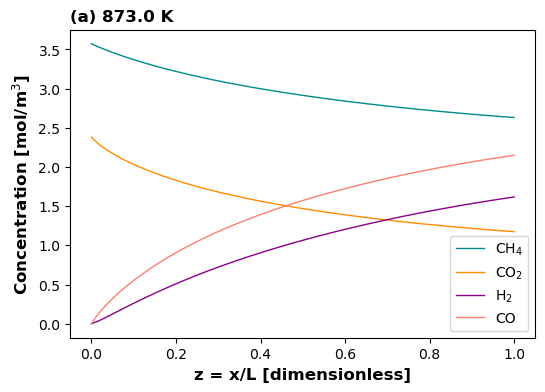

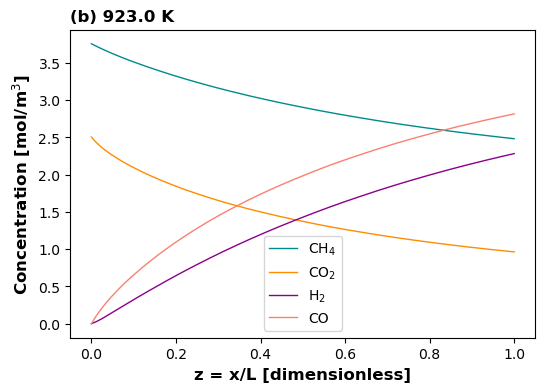

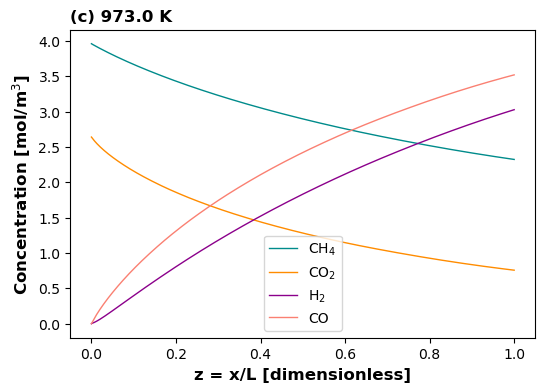

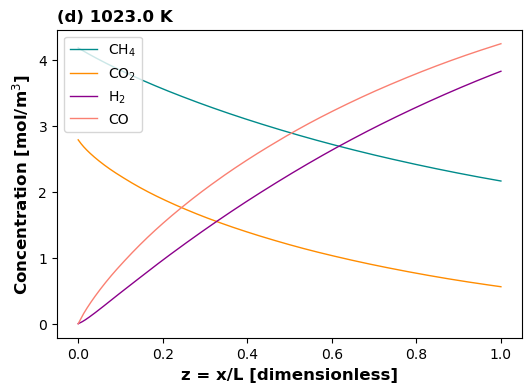

In [18]:
def pfr(z, Y):
    
    # molar rates
    Fch4, Fco2, Fh2o, Fh2, Fco, Far, T, Th, P  = Y
    Ftotal = Fch4 + Fco2 + Fh2o + Fh2 + Fco + Far
    
    # molar ratios
    ych4 = Fch4/Ftotal; yco2 = Fco2/Ftotal; yh2o = Fh2o/Ftotal; yh2 = Fh2/Ftotal;
    yco = Fco/Ftotal; yar = Far/Ftotal
    
    # call total density
    Ctotal = ideal_gas(873, 101325, 0.3, 0.2, 0.0, 0.0, 0.0, 0.5)[6]
    initFlow = Ctotal*q_m3
    
    # call gas mixture molar mass and density
    Mr_mix = Mr_mixture(ych4, yco2, yh2o, yh2, yco, yar)[0] 
    d_mix = ideal_gas(T, P, ych4, yco2, yh2o, yh2, yco, yar)[7]
    
    # call kinetic parameters
    k_SRM1, k_SRM2, k_WGS, k_DRM = k(T)[0], k(T)[1], k(T)[2], k(T)[3]
    
    # call adsorption parameters
    K_ch4, K_h2o, K_co, K_h2 = K(T)[0], K(T)[1], K(T)[2], K(T)[3]
    
    # call equilibrium parameters
    Kpsrm1, Kpsrm2, KpWGS, KpDRM = Keq(T)[0], Keq(T)[1], Keq(T)[2], Keq(T)[3]
    
    # call specific heats
    Cp_ch4 = heat_cap(T, ych4, yco2, yh2o, yh2, yco, yar)[0]
    Cp_co2 = heat_cap(T, ych4, yco2, yh2o, yh2, yco, yar)[1]
    Cp_h2o = heat_cap(T, ych4, yco2, yh2o, yh2, yco, yar)[2]
    Cp_h2 = heat_cap(T, ych4, yco2, yh2o, yh2, yco, yar)[3]
    Cp_co = heat_cap(T, ych4, yco2, yh2o, yh2, yco, yar)[4]
    Cp_ar = heat_cap(T, ych4, yco2, yh2o, yh2, yco, yar)[5]
    Cp_mix_mole = heat_cap(T, ych4, yco2, yh2o, yh2, yco, yar)[6]
    
    # call enthalpies
    Hrxn_SRM1 = 1000*thermSRM1(T)[1]
    Hrxn_SRM2 = 1000*thermSRM2(T)[1]
    Hrxn_WGS = 1000*thermWGS(T)[1]
    Hrxn_DRM = 1000*thermDRM(T)[1]
    
    # effectiveness factors
    heta1 = 0.93e-02
    heta2 = 0.41e-02
    heta3 = 1.0
    heta4 = 1.0
    
    # call rates
    R1 = rates(T, ych4, yco2, yh2o, yh2, yco)[0]
    R2 = rates(T, ych4, yco2, yh2o, yh2, yco)[1]
    R3 = rates(T, ych4, yco2, yh2o, yh2, yco)[2]
    R4 = rates(T, ych4, yco2, yh2o, yh2, yco)[3]
    
    rch4 = rates(T, ych4, yco2, yh2o, yh2, yco)[4]
    rco2 = rates(T, ych4, yco2, yh2o, yh2, yco)[5]
    rh2o = rates(T, ych4, yco2, yh2o, yh2, yco)[6]
    rh2 = rates(T, ych4, yco2, yh2o, yh2, yco)[7]
    rco = rates(T, ych4, yco2, yh2o, yh2, yco)[8]
    rar = 0
    
    # mass balance
    dFch4 = rch4*d_bulk*reactor_area
    dFco2 = rco2*d_bulk*reactor_area
    dFh2o = rh2o*d_bulk*reactor_area
    dFh2 = rh2*d_bulk*reactor_area
    dFco = rco*d_bulk*reactor_area
    dFar = rar*d_bulk*reactor_area
    
    # energy balance 1
    Ener_sum = heta1*(-Hrxn_SRM1)*R1 + heta2*(-Hrxn_SRM2)*R2 + heta3*(-Hrxn_WGS)*R3 + heta4*(-Hrxn_DRM)*R4
    alphaT = reactor_area*(Uw*av*(Th-T)) + Ener_sum*d_bulk
    betaT = Fch4*Cp_ch4 + Fco2*Cp_co2 + Fh2o*Cp_h2o + Fh2*Cp_h2 + Fco*Cp_co + Far*Cp_ar
    dT = alphaT/betaT
    
    # energy balance 2
    heatMFR = 900 # kg/h
    maxLength = 5.0
    numberOfTubes = 1
    heatMolarFlowRate = (heatMFR)/(3600*Mr_mix) # mol/s
    alphaTh = Uw*reactor_area*(Th-T)*numberOfTubes
    betaTh = heatMolarFlowRate*Cp_mix_mole*maxLength
    dTh = alphaTh/betaTh
    
    # pressure drop
    alphaP = (-d_mix*velo)/(d_mix*d_particle)
    betaP = (1-epsilon)/(epsilon**3)
    charlieP = (150*(1-epsilon)*mu_g)/d_particle
    deltaP = 1.75*d_mix*velo
    pTerm = alphaP*betaP*(charlieP+deltaP)
    dP = pTerm*(101325/P)*(Ftotal/initFlow)
    
    return np.array([dFch4, dFco2, dFh2o, dFh2, dFco, dFar, dT, dTh, dP], dtype = object)

# set the parameters to solve the differential equations
Lspan = np.linspace(0, reactor_length, 1000)
dimensionless = Lspan/reactor_length


# create empty lists and arrays to place results for each temperature 
X_ch4_T = []
X_co2_T = []
X_co_T = []
X_h2_T = []
T_all = []

Temp_range = np.linspace(873.15, 1023.15, 4)

# initial points are set for each temperature
Fch4_all = np.array([])
Fco2_all = np.array([])
Far_all = np.array([])

for Temp in Temp_range:
    
    Cch4_T = ideal_gas(Temp, 101325, 0.3, 0.2, 0.0, 0.0, 0.0, 0.5)[0] # mol/m3
    Fch4_all = np.append(Cch4_T*q_m3, Fch4_all)
    
    Cco2_T = ideal_gas(Temp, 101325, 0.3, 0.2, 0.0, 0.0, 0.0, 0.5)[1] # mol/m3
    Fco2_all = np.append(Cco2_T*q_m3, Fco2_all)
    
    Car_T = ideal_gas(Temp, 101325, 0.3, 0.2, 0.0, 0.0, 0.0, 0.5)[5] # mol/m3
    Far_all = np.append(Car_T*q_m3, Far_all)
    

letters = ['(a)', '(b)', '(c)', '(d)']

for Temp, letter, Fch4_i, Fco2_i, Far_i in zip(Temp_range, letters, Fch4_all, Fco2_all, Far_all):

    y0 = np.array([Fch4_i, Fco2_i, Fch4_i/300, 1e-12, 1e-12, Far_i, Temp, Temp - 30, 101325])
    
    sol = solve_ivp(pfr, [Lspan[0], Lspan[-1]], y0, method = "BDF", t_eval = Lspan)
    Fch4, Fco2, Fh2o, Fh2, Fco, Far, p, T, Th = sol.y
    
    Cch4 = Fch4/q_m3; Cco2 = Fco2/q_m3; Ch2o = Fh2o/q_m3; Ch2 = Fh2/q_m3;
    Cco = Fco/q_m3; Car = Far/q_m3
    
    X_ch4 = (1.0 - (Fch4/(Fch4_i)))*100
    X_co2 = (1.0 - (Fco2/(Fco2_i)))*100
    X_h2 = ((Fh2/(2*Fch4_i)))*100
    X_co = ((Fco/(Fch4_i + Fco2_i)))*100
    
    X_ch4_T.append(X_ch4[-1])
    X_co2_T.append(X_co2[-1])
    X_h2_T.append(X_h2[-1])
    X_co_T.append(X_co[-1])
    T_all.append(T)
    
    plt.figure(figsize=(6, 4), dpi=100)
    plt.xlabel('z = x/L [dimensionless]', fontsize=12, fontweight='bold')
    plt.ylabel('Concentration [mol/m$^3$]', fontsize=12, fontweight='bold')
    plt.plot(dimensionless, Cch4, '-', color = 'darkcyan', label = 'CH$_4$', lw = 1)
    plt.plot(dimensionless, Cco2, '-', color = 'darkorange', label = 'CO$_2$', lw = 1)
    plt.plot(dimensionless, Ch2, '-', color = 'darkmagenta', label = 'H$_2$', lw = 1) 
    plt.plot(dimensionless, Cco, '-', color = 'salmon', label = 'CO', lw = 1)  
    plt.legend()
    
    plt.title('{} {} K'.format(letter, round(Temp, 0)), loc='left', fontsize=12, fontweight='bold') 
    plt.legend()

In [26]:
# experimental data
XYi_LNO = np.array([
    [18.11969859, 32.75254077, 45.96614523, 51.45145986], # ch4
    [41.43185785, 63.01822552, 77.92276051, 85.25478537], # co2
    [15.80229266, 30.65212353, 44.81390812, 51.48408266], # h2
    [27.38348021, 46.17382732, 60.10058472, 67.60816721], # co
    ])

Xch4_LNO, Xco2_LNO, Yh2_LNO, Yco_LNO = XYi_LNO

# equalibrium data for DRM reaction for a mixture of ych4 = 0.3, yco2 = 0.2, yh2o = 0, yh2 = 0.0, yco = 0,  yar =0.5
XYi_eq = np.array([
    [51.4796499, 63.7602808, 71.3905802, 74.703341],
    [75.3302053, 88.7035541, 96.0406703, 98.8825356],
    [29.58705967, 38.177447, 43.83893467, 46.41145467],
    [41.7150034, 49.8274848, 54.4791486, 56.361266]
    ])

Xch4_eq, Xco2_eq, YH2_eq, YCO_eq = XYi_eq

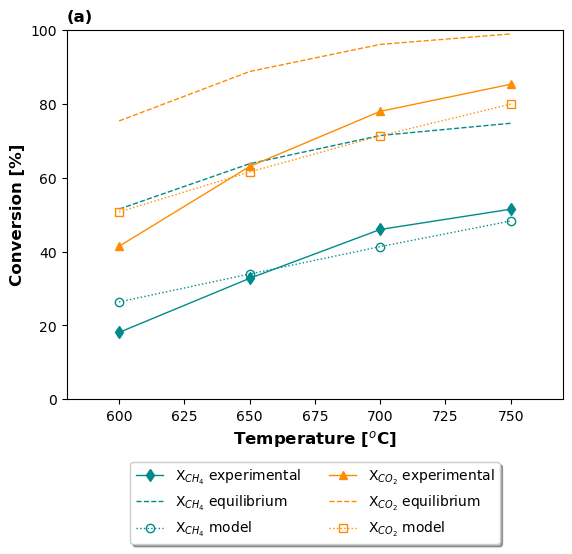

In [27]:
# conversion plots
plt.plot(np.linspace(600, 750, 4), Xch4_LNO, '-d', color = 'darkcyan', label='X$_{CH_4}$ experimental', lw = 1)
plt.plot(np.linspace(600, 750, 4), Xch4_eq, '--', color = 'darkcyan', label='X$_{CH_4}$ equilibrium', lw = 1)
plt.plot(np.linspace(600, 750, 4), X_ch4_T, ':o', color = 'darkcyan', mfc = 'none', label = 'X$_{CH_4}$ model', lw = 1)

plt.plot(np.linspace(600, 750, 4), Xco2_LNO, '-^', color = 'darkorange', label = 'X$_{CO_2}$ experimental', lw = 1)
plt.plot(np.linspace(600, 750, 4), Xco2_eq, '--', color = 'darkorange', label = 'X$_{CO_2}$ equilibrium', lw = 1)
plt.plot(np.linspace(600, 750, 4), X_co2_T, ':s', color = 'darkorange', mfc = 'none', label = 'X$_{CO_2}$ model', lw = 1)

plt.ylim(0, 100)
plt.xlim(580, 770)
plt.xlabel('Temperature [$^o$C]', fontsize=12, fontweight='bold')
plt.ylabel('Conversion [%]', fontsize=12, fontweight='bold')
plt.title('(a)', loc='left', fontsize=12, fontweight='bold')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=2)

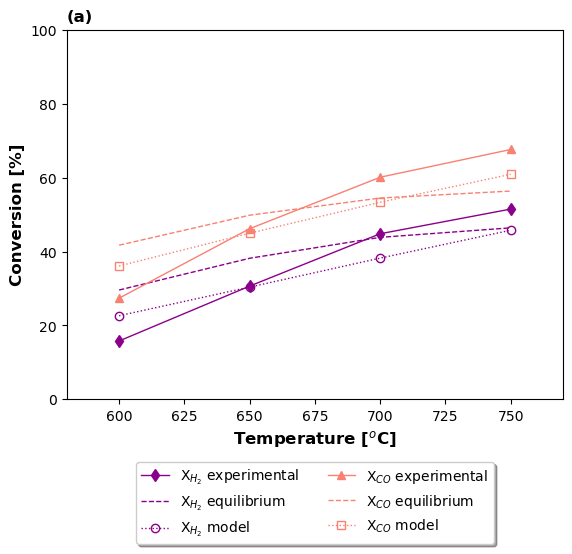

In [28]:
# yield plots
plt.plot(np.linspace(600, 750, 4), Yh2_LNO, '-d', color = 'darkmagenta', label='X$_{H_2}$ experimental', lw = 1)
plt.plot(np.linspace(600, 750, 4), YH2_eq, '--', color = 'darkmagenta', label='X$_{H_2}$ equilibrium', lw = 1)
plt.plot(np.linspace(600, 750, 4), X_h2_T, ':o', color = 'darkmagenta', mfc = 'none', label = 'X$_{H_2}$ model', lw = 1)

plt.plot(np.linspace(600, 750, 4), Yco_LNO, '-^', color = 'salmon', label = 'X$_{CO}$ experimental', lw = 1)
plt.plot(np.linspace(600, 750, 4), YCO_eq, '--', color = 'salmon', label = 'X$_{CO}$ equilibrium', lw = 1)
plt.plot(np.linspace(600, 750, 4), X_co_T, ':s', color = 'salmon', mfc = 'none', label = 'X$_{CO}$ model', lw = 1)

plt.ylim(0, 100)
plt.xlim(580, 770)
plt.xlabel('Temperature [$^o$C]', fontsize=12, fontweight='bold')
plt.ylabel('Conversion [%]', fontsize=12, fontweight='bold')
plt.title('(a)', loc='left', fontsize=12, fontweight='bold')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=2)